# Combine the analysis tiles

And mask regions such as urban, agriculture, and water bodies.

In [1]:
%matplotlib inline

import os
import sys
import warnings
import numpy as np
import xarray as xr
import pandas as pd
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords


/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
data_type = 'AusEFlux_GPP_1982_2022'  #'AusEFlux_GPP' 'DIFFUSE_GPP' 'NDVI_1982_2022' 'MODIS_GPP' 'PML_GPP' 
tiles_path = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/tiles/{data_type}/'
export=f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/combined_tiles/{data_type}/'

## Open masking datasets

In [3]:
crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = xr.where(crops==1, 0, 1) #irrigated crops
crops = round_coords(crops)

urban = xr.open_dataarray('/g/data/xc0/project/AusEFlux/data/urban_water_mask_5km.nc')
mask = (urban | crops)

mask = ~mask.astype('bool')

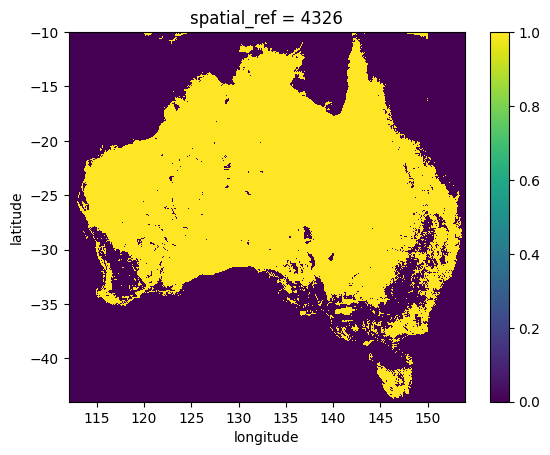

In [4]:
mask.plot()

## Join tiles together

and mask with urban etc.

In [5]:
def combine_tiles(path, v, mask):
    tiles = [path+i for i in os.listdir(path) if v in i]
    tiles = [xr.open_dataset(t) for t in tiles]
    p = xr.combine_by_coords(tiles)
    p = assign_crs(p,crs='EPSG:4326')
    
    for var in p.data_vars:
        try:
            del p[var].attrs['grid_mapping']
        except:
            continue

    # mask = (urban & crops)
    p = p.where(mask)
    return p

p_trends = combine_tiles(tiles_path, 'trends', mask)
p_beta = combine_tiles(tiles_path, 'beta', mask)
p_attribute_pls = combine_tiles(tiles_path, 'PLS', mask)
p_attribute_delta_slope = combine_tiles(tiles_path, 'delta_slope', mask)
p_attribute_ml = combine_tiles(tiles_path, 'ML', mask)


## Interactive maps

In [6]:
# p_trends['slope'].odc.explore( #.where(p_trends['p_value']<=0.1)
#     tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#     attr = 'Esri',
#     name = 'Esri Satellite',
#     cmap='BrBG',
#     robust=True
# )

In [7]:
# p_beta['beta_relative'].where(p_beta['pvalue']<=0.1).odc.explore( #.where(p_trends['p_value']<=0.1)
#     tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#     attr = 'Esri',
#     name = 'Esri Satellite',
#     cmap='magma',
#     robust=True
# )

## Export

In [8]:
p_trends.to_netcdf(f'{export}/trends_{data_type}.nc')
p_beta.to_netcdf(f'{export}beta_{data_type}.nc')
p_attribute_pls.to_netcdf(f'{export}attribution_PLS_{data_type}.nc')
p_attribute_ml.to_netcdf(f'{export}attribution_ML_{data_type}.nc')
p_attribute_delta_slope.to_netcdf(f'{export}/attribution_delta_slope_{data_type}.nc')